# Project: Classification




In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

## Part 1. Getting acquainted with the data, handling missing values and outliers.

### Assignment 1

In [2]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load data
df = pd.read_csv('drive/MyDrive/dataForCollab/DS/Project4/bank_fin.csv', sep = ';')

In [4]:
# Explore the data for missing values. Where are there missing values? How many are there?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


The 'balance' feature is of a object type, we need to change it, but lets first look into it.

### Assignment 2

In [6]:
# are there any missing values in the 'job' feature? Could they possibly be denoted by some special word?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

The missing values in the 'job' feature are denoted by 'unknow' values

### Assignment 3

In [7]:
# translate the 'balance' feature in such a way that it is correctly read as a floating-point number (float).
df['balance'] = df['balance'].str.replace(',', '.')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].astype(float)

# calculate the average for the balance after we corrected it to the right format
df['balance'].mean().round(3)

1529.129

### Assignment 4

In [8]:
# Handle the missing values in the 'balance' feature by replacing them with the median values for this feature.
df['balance'].fillna(df['balance'].median(), inplace=True)

# the mean of the balance column after we replaced the missing values with the median values of the balance column
mean = df['balance'].mean().round(3)
print('The average customers balance after we replaced the missing values with median values: ', mean)

1526.936

### Assignment 5

In [9]:
# Handle the missing values in the categorical features: 'job' and 'education', replacing them with the mode values.

# finding the most popular job and education
popular_job = df['job'].mode()[0]
popular_education = df['education'].mode()[0]

# replacing the 'unknown' values with the most popular in 'job' and 'education' categories
df['job'] = df['job'].apply(lambda x: popular_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: popular_education if x == 'unknown' else x)

# Task 2.5
# After replacing missing values, calculate the average balance
# for clients with the most popular job and the most popular level of education
# (i.e., for those who have both the most popular job and the most popular education). Round the answer to three decimal places.
df[(df['job'] == popular_job) & (df['education'] == popular_education)]['balance'].mean().round(3)

1598.883

### Assignment 6

In [10]:
# Delete all outliers for the 'balance' feature.

# determine quantila1 and quantile3
q1 = df['balance'].quantile(0.25)
q3 = df['balance'].quantile(0.75)

# calculate IQR
iqr = q3 - q1

# calculate the lower and upper bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# remove the items from df that fall below lower bound or above upper bound
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

# print the lower bound, upper bound and new shape of data frame
print('Lower Bound: ', lower_bound)
print('Upper Bound: ', upper_bound)
print('The new shape of data frame: ', df.shape[0])

Lower Bound:  -2241.0
Upper Bound:  4063.0
The new shape of data frame:  10105


## Part 2:  EDA

### Assignment 1

no     5424
yes    4681
Name: deposit, dtype: int64


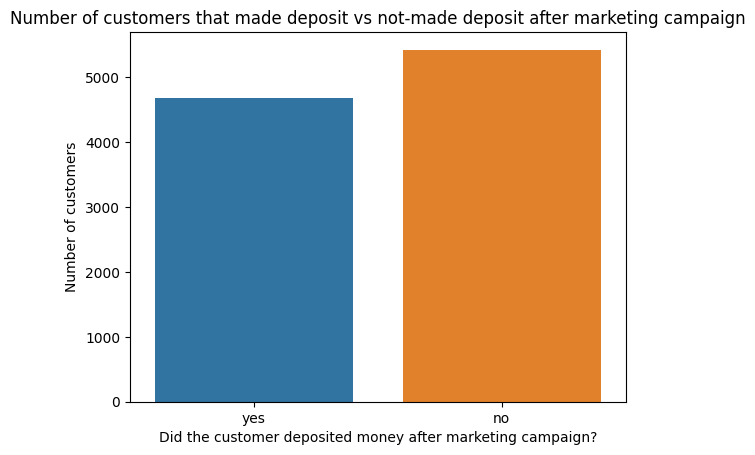

In [11]:
# study the class distribution in your data for imbalance and illustrate the result.
sns.countplot(data=df, x='deposit')
plt.title('Number of customers that made deposit vs not-made deposit after marketing campaign')
plt.xlabel('Did the customer deposited money after marketing campaign?')
plt.ylabel('Number of customers')
print(df['deposit'].value_counts())

### Assignment 2 and 3

                age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  


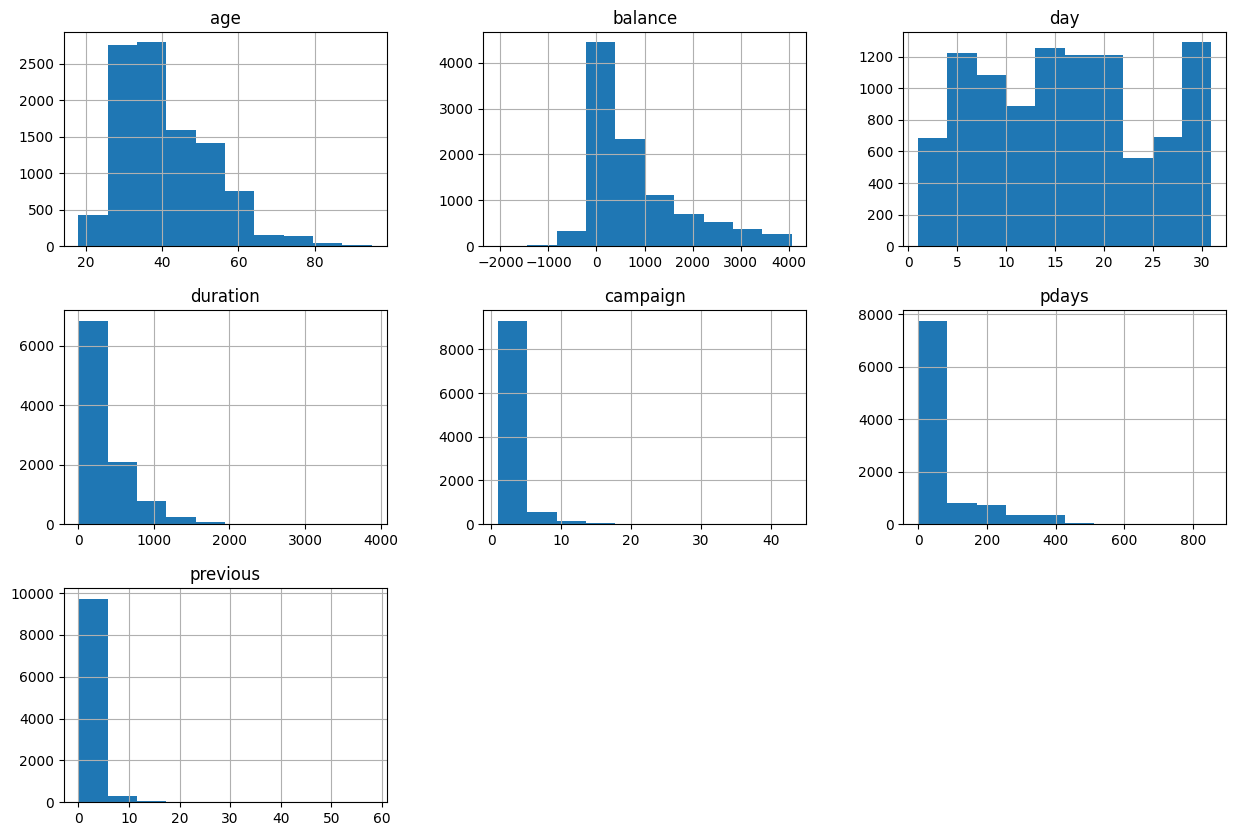

In [12]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
print(df.describe())
df.hist(figsize=(15, 10))
plt.show()

### Задания 4 и 5

The number of different month that marketing campaign was running: 12
The number of different job that customers have: 11


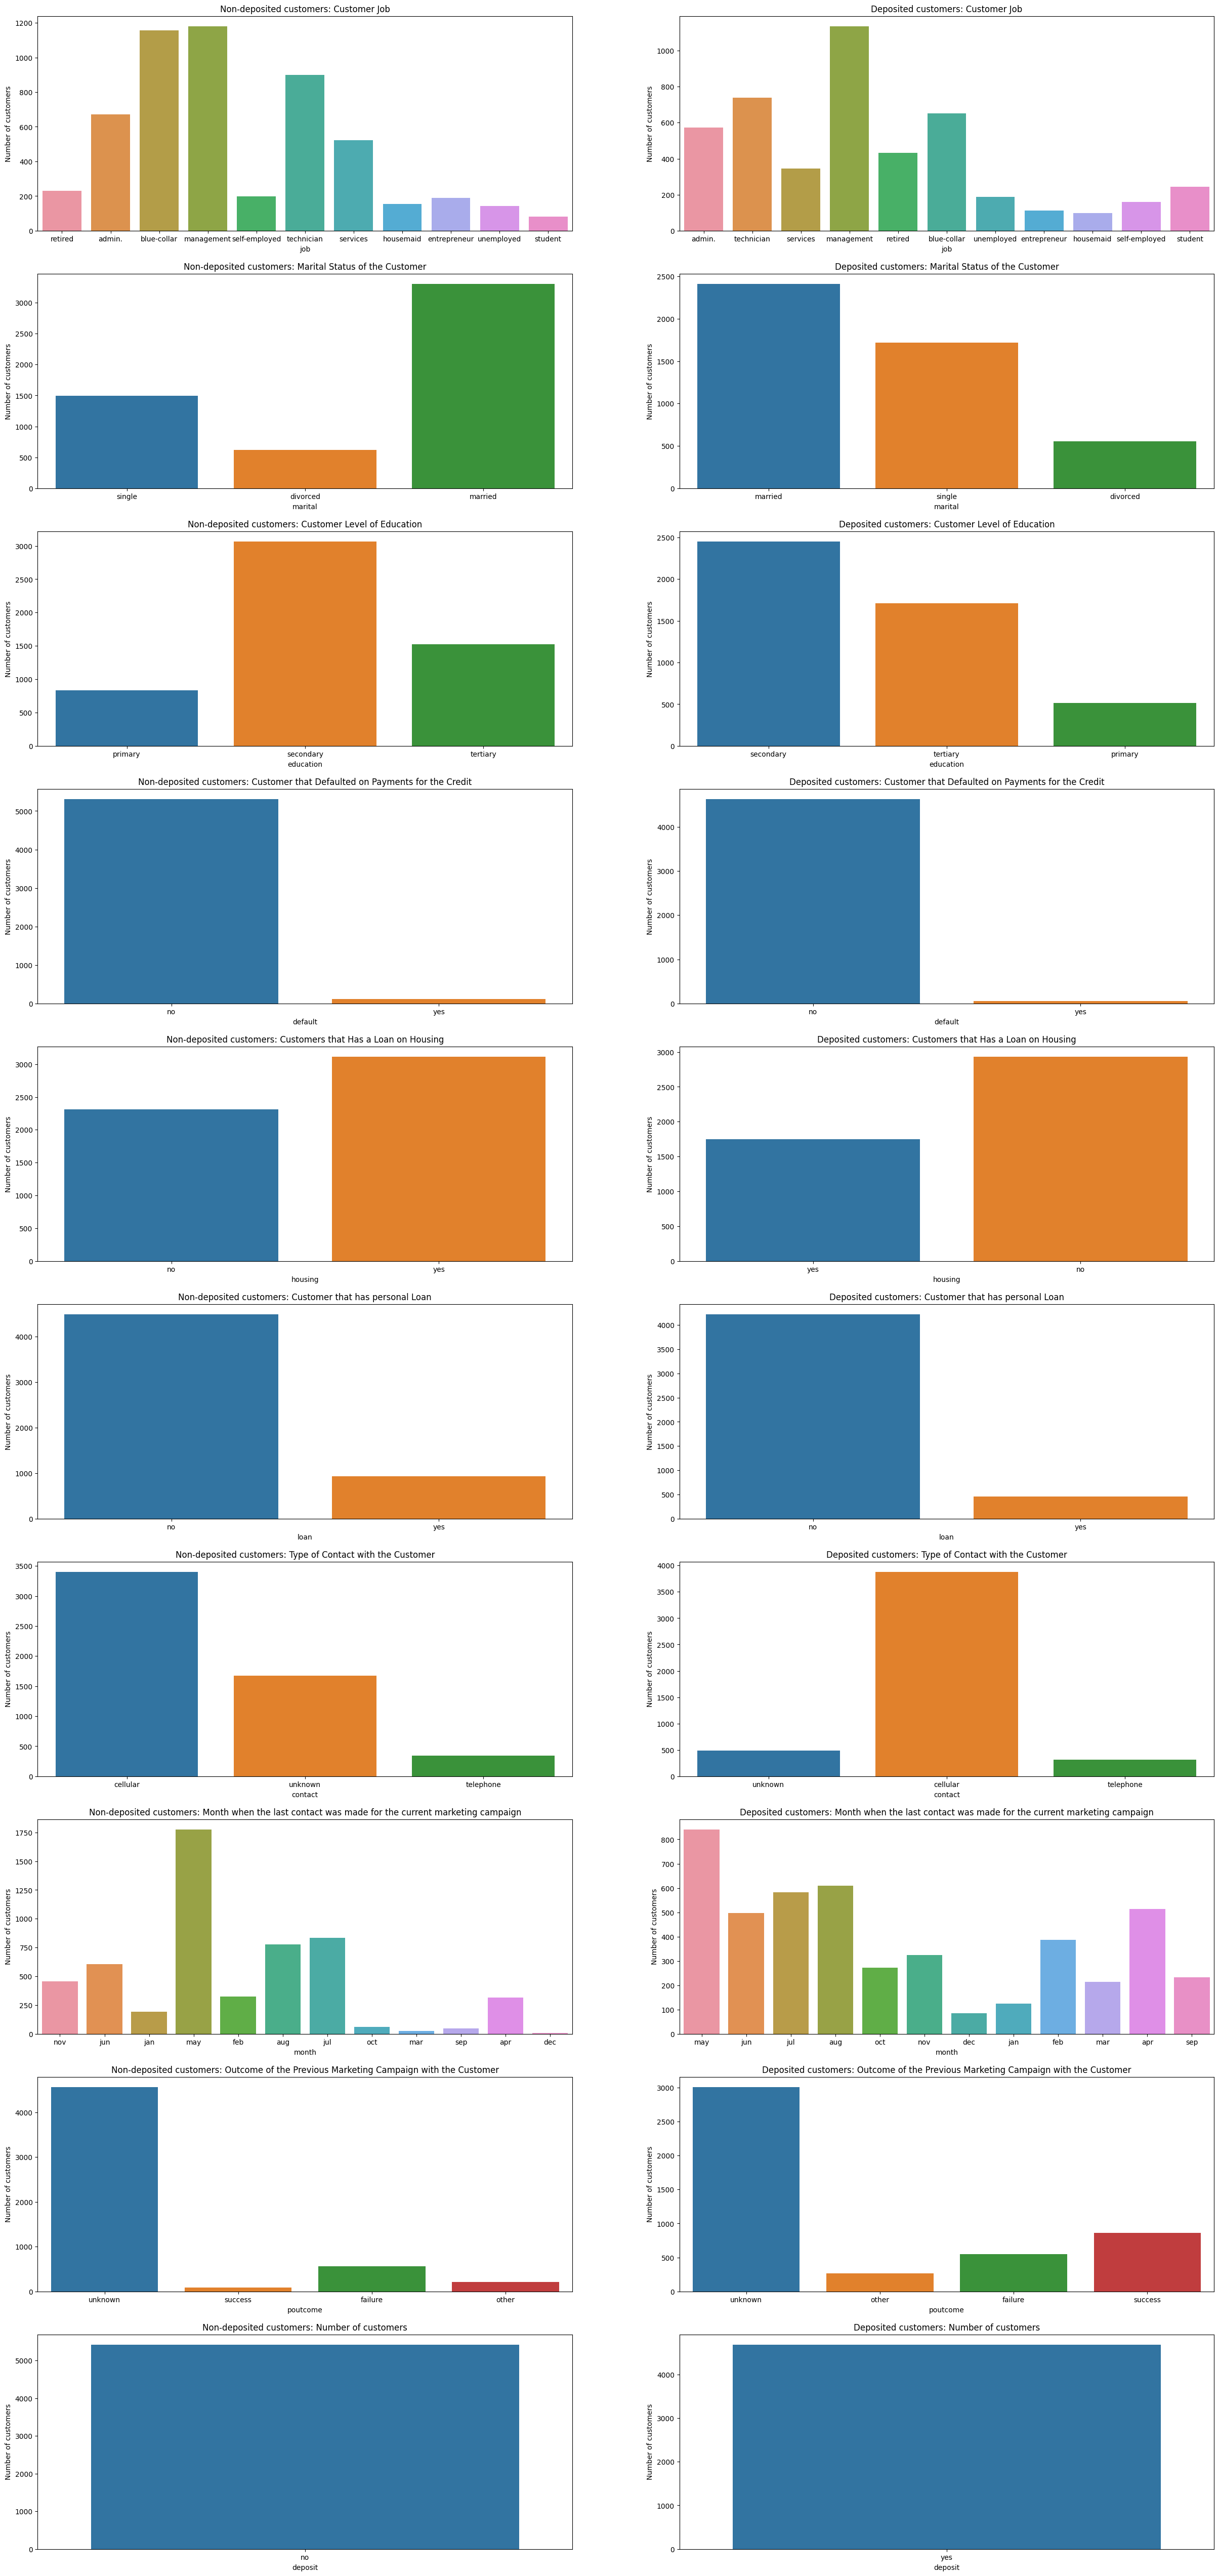

In [13]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#постройте визуализации, иллюстрирующие результаты

# create a list of categorical columns
cat_columns = df.select_dtypes(include=['object']).columns

# create a dataframe with categorical features
cat_features = df[cat_columns]

# create a dictionary with customer related information for categorical features
customers_features = {
  'job': 'Customer Job',
  'marital': 'Marital Status of the Customer',
  'education': 'Customer Level of Education',
  'default': 'Customer that Defaulted on Payments for the Credit',
  'housing': 'Customers that Has a Loan on Housing',
  'loan': 'Customer that has personal Loan',
  'contact': 'Type of Contact with the Customer',
  'poutcome': 'Outcome of the Previous Marketing Campaign with the Customer',
  'month': 'Month when the last contact was made for the current marketing campaign',
  'day_of_week': 'Day when the last contact was made for the current marketing campaign',
  'deposit': 'Number of customers'
}

# create a subplots with two columns
# left column for customers that not made deposit, right one that made deposit
fig, axes = plt.subplots(nrows=len(cat_columns), ncols=2, figsize=(30, 65))

for i, feature in enumerate(cat_columns):
  # data frame for customers that not made deposit
  df_not_deposit = df[df['deposit'] == 'no']

  # data frame for customers that made deposit
  df_deposit = df[df['deposit'] == 'yes']

  # countplot for customers that not made deposit
  sns.countplot(data=df_not_deposit, x=feature, ax=axes[i, 0])
  axes[i, 0].set_title(f'Non-deposited customers: {customers_features[feature]}')
  axes[i, 0].set_ylabel('Number of customers')



  # countplot for customers that made deposit
  sns.countplot(data=df_deposit, x=feature, ax=axes[i, 1])
  axes[i, 1].set_title(f'Deposited customers: {customers_features[feature]}')
  axes[i, 1].set_ylabel('Number of customers')

# Задание 3.4
# Сколько было месяцев, в которых проводилась маркетинговая кампания?
print(f'The number of different month that marketing campaign was running: {cat_features["month"].nunique()}')

# Задание 3.5
# Сколько сфер занятости представлено среди клиентов банка?
print(f'The number of different job that customers have: {cat_features["job"].nunique()}')

### Задание 6

<Axes: xlabel='poutcome'>

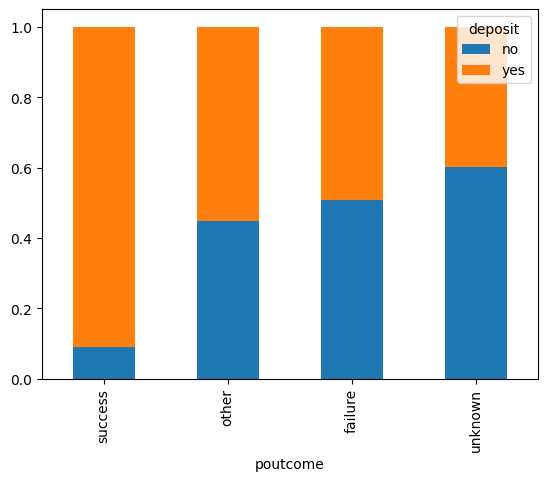

In [14]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
poutcome = df.groupby('poutcome')['deposit'].value_counts(normalize=True).unstack().sort_values(by='yes', ascending=False)
poutcome.plot(kind='bar', stacked=True)

### Задание 7

<Axes: xlabel='month'>

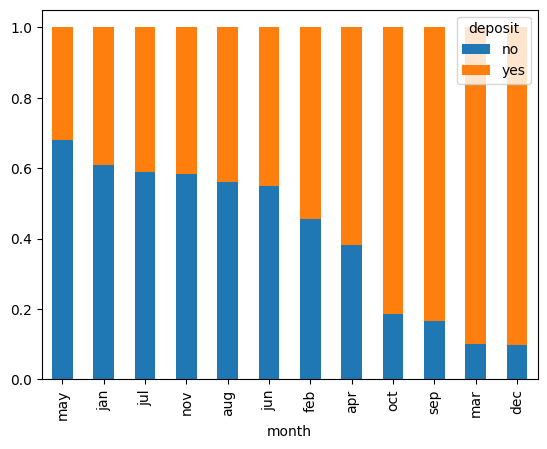

In [15]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
month = df.groupby('month')['deposit'].value_counts(normalize=True).unstack().sort_values(by='yes')
month.plot(kind='bar', stacked=True)

### Задание 8

<Axes: xlabel='age_group'>

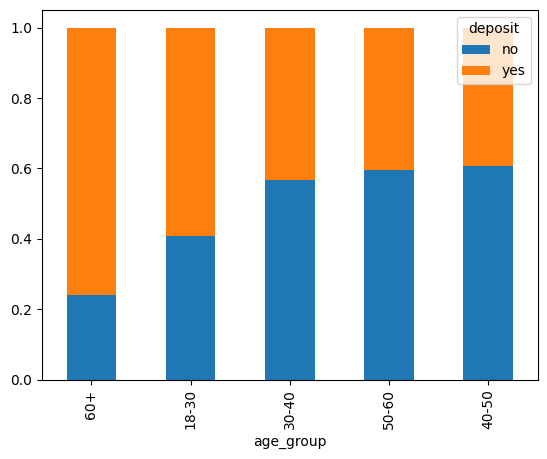

In [16]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group(age):
  if age < 30:
    return '18-30'
  elif age < 40:
    return '30-40'
  elif age < 50:
    return '40-50'
  elif age < 60:
    return '50-60'
  else:
    return '60+'

df['age_group'] = df['age'].apply(age_group)

age_group = df.groupby('age_group')['deposit'].value_counts(normalize=True).unstack().sort_values(by='yes', ascending=False)
age_group.plot(kind='bar', stacked=True)

### Задания 9 и 10

<Axes: xlabel='marital'>

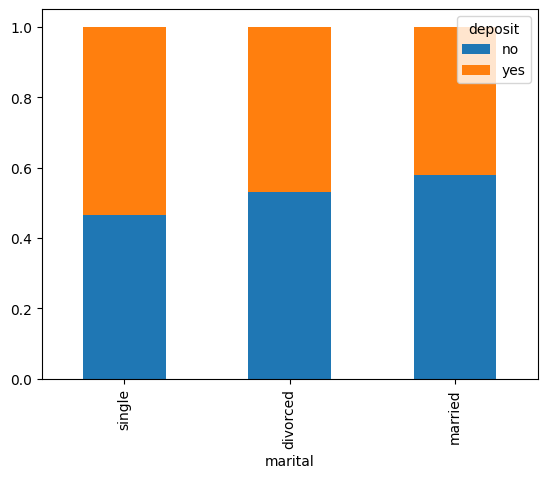

In [17]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
marriage = df.groupby('marital')['deposit'].value_counts(normalize=True).unstack().sort_values(by='yes', ascending=False)
marriage.plot(kind='bar', stacked=True)

<Axes: xlabel='education'>

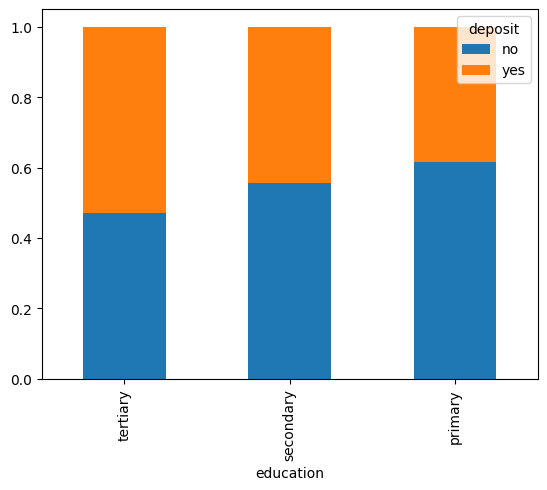

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
education = df.groupby('education')['deposit'].value_counts(normalize=True).unstack().sort_values(by='yes', ascending=False)
education.plot(kind='bar', stacked=True)

<Axes: xlabel='job'>

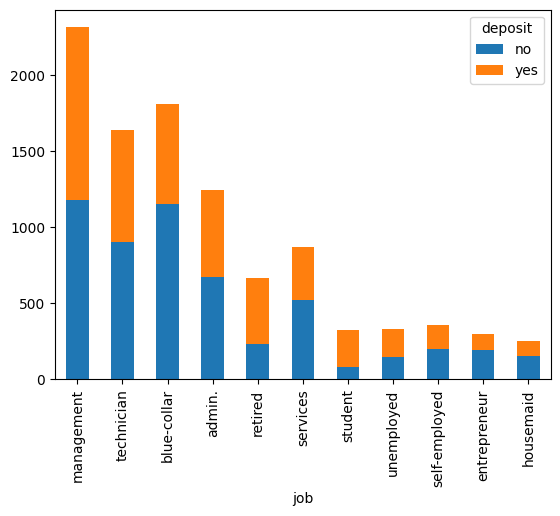

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
job = df.groupby('job')['deposit'].value_counts().unstack().sort_values(by='yes', ascending=False)
job.plot(kind='bar', stacked=True)

### Задание 11

In [20]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
education_marital = df[cat_features['deposit']=='yes'].groupby(['education', 'marital'])['deposit'].count().sort_values(ascending=False)
education_marital

education  marital 
secondary  married     1289
           single       879
tertiary   married      784
           single       755
primary    married      339
secondary  divorced     283
tertiary   divorced     174
primary    divorced      96
           single        82
Name: deposit, dtype: int64

## Часть 3: преобразование данных

### Задание 1

In [21]:
# преобразуйте уровни образования
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])

#Задание 4.1
#Найдите сумму получившихся значений для признака education.
print(df['education'].sum())

# Ранее мы создали порядковую переменную для возраста.
# Обработайте её по такому же принципу, чтобы её можно было использовать при обучении модели.
df['age_group'] = label_encoder.fit_transform(df['age_group'])

11995


### Задания 2 и 3

In [22]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

#Задание 4.2
#Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit.
#Ответ округлите до трёх знаков после точки-разделителя
df['deposit'].describe()

count    10105.000000
mean         0.463236
std          0.498671
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: deposit, dtype: float64

In [23]:
#Задание 4.3
#Вычислите среднее арифметическое для каждой из получившихся переменных,
#сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.
default_mean = df['default'].mean()
housing_mean = df['housing'].mean()
loan_mean = df['loan'].mean()

print(round(default_mean + housing_mean + loan_mean, 3))

0.635


### Задание 4

In [24]:
# создайте дамми-переменные
dummies_data = df[['job', 'marital', 'contact', 'month', 'poutcome']]
dummies = pd.get_dummies(dummies_data)
df = pd.concat([df, dummies], axis=1)
df.shape

(10105, 51)

### Задания 5 и 6

<Axes: title={'center': 'Coefficients of Correlation with Target variable'}>

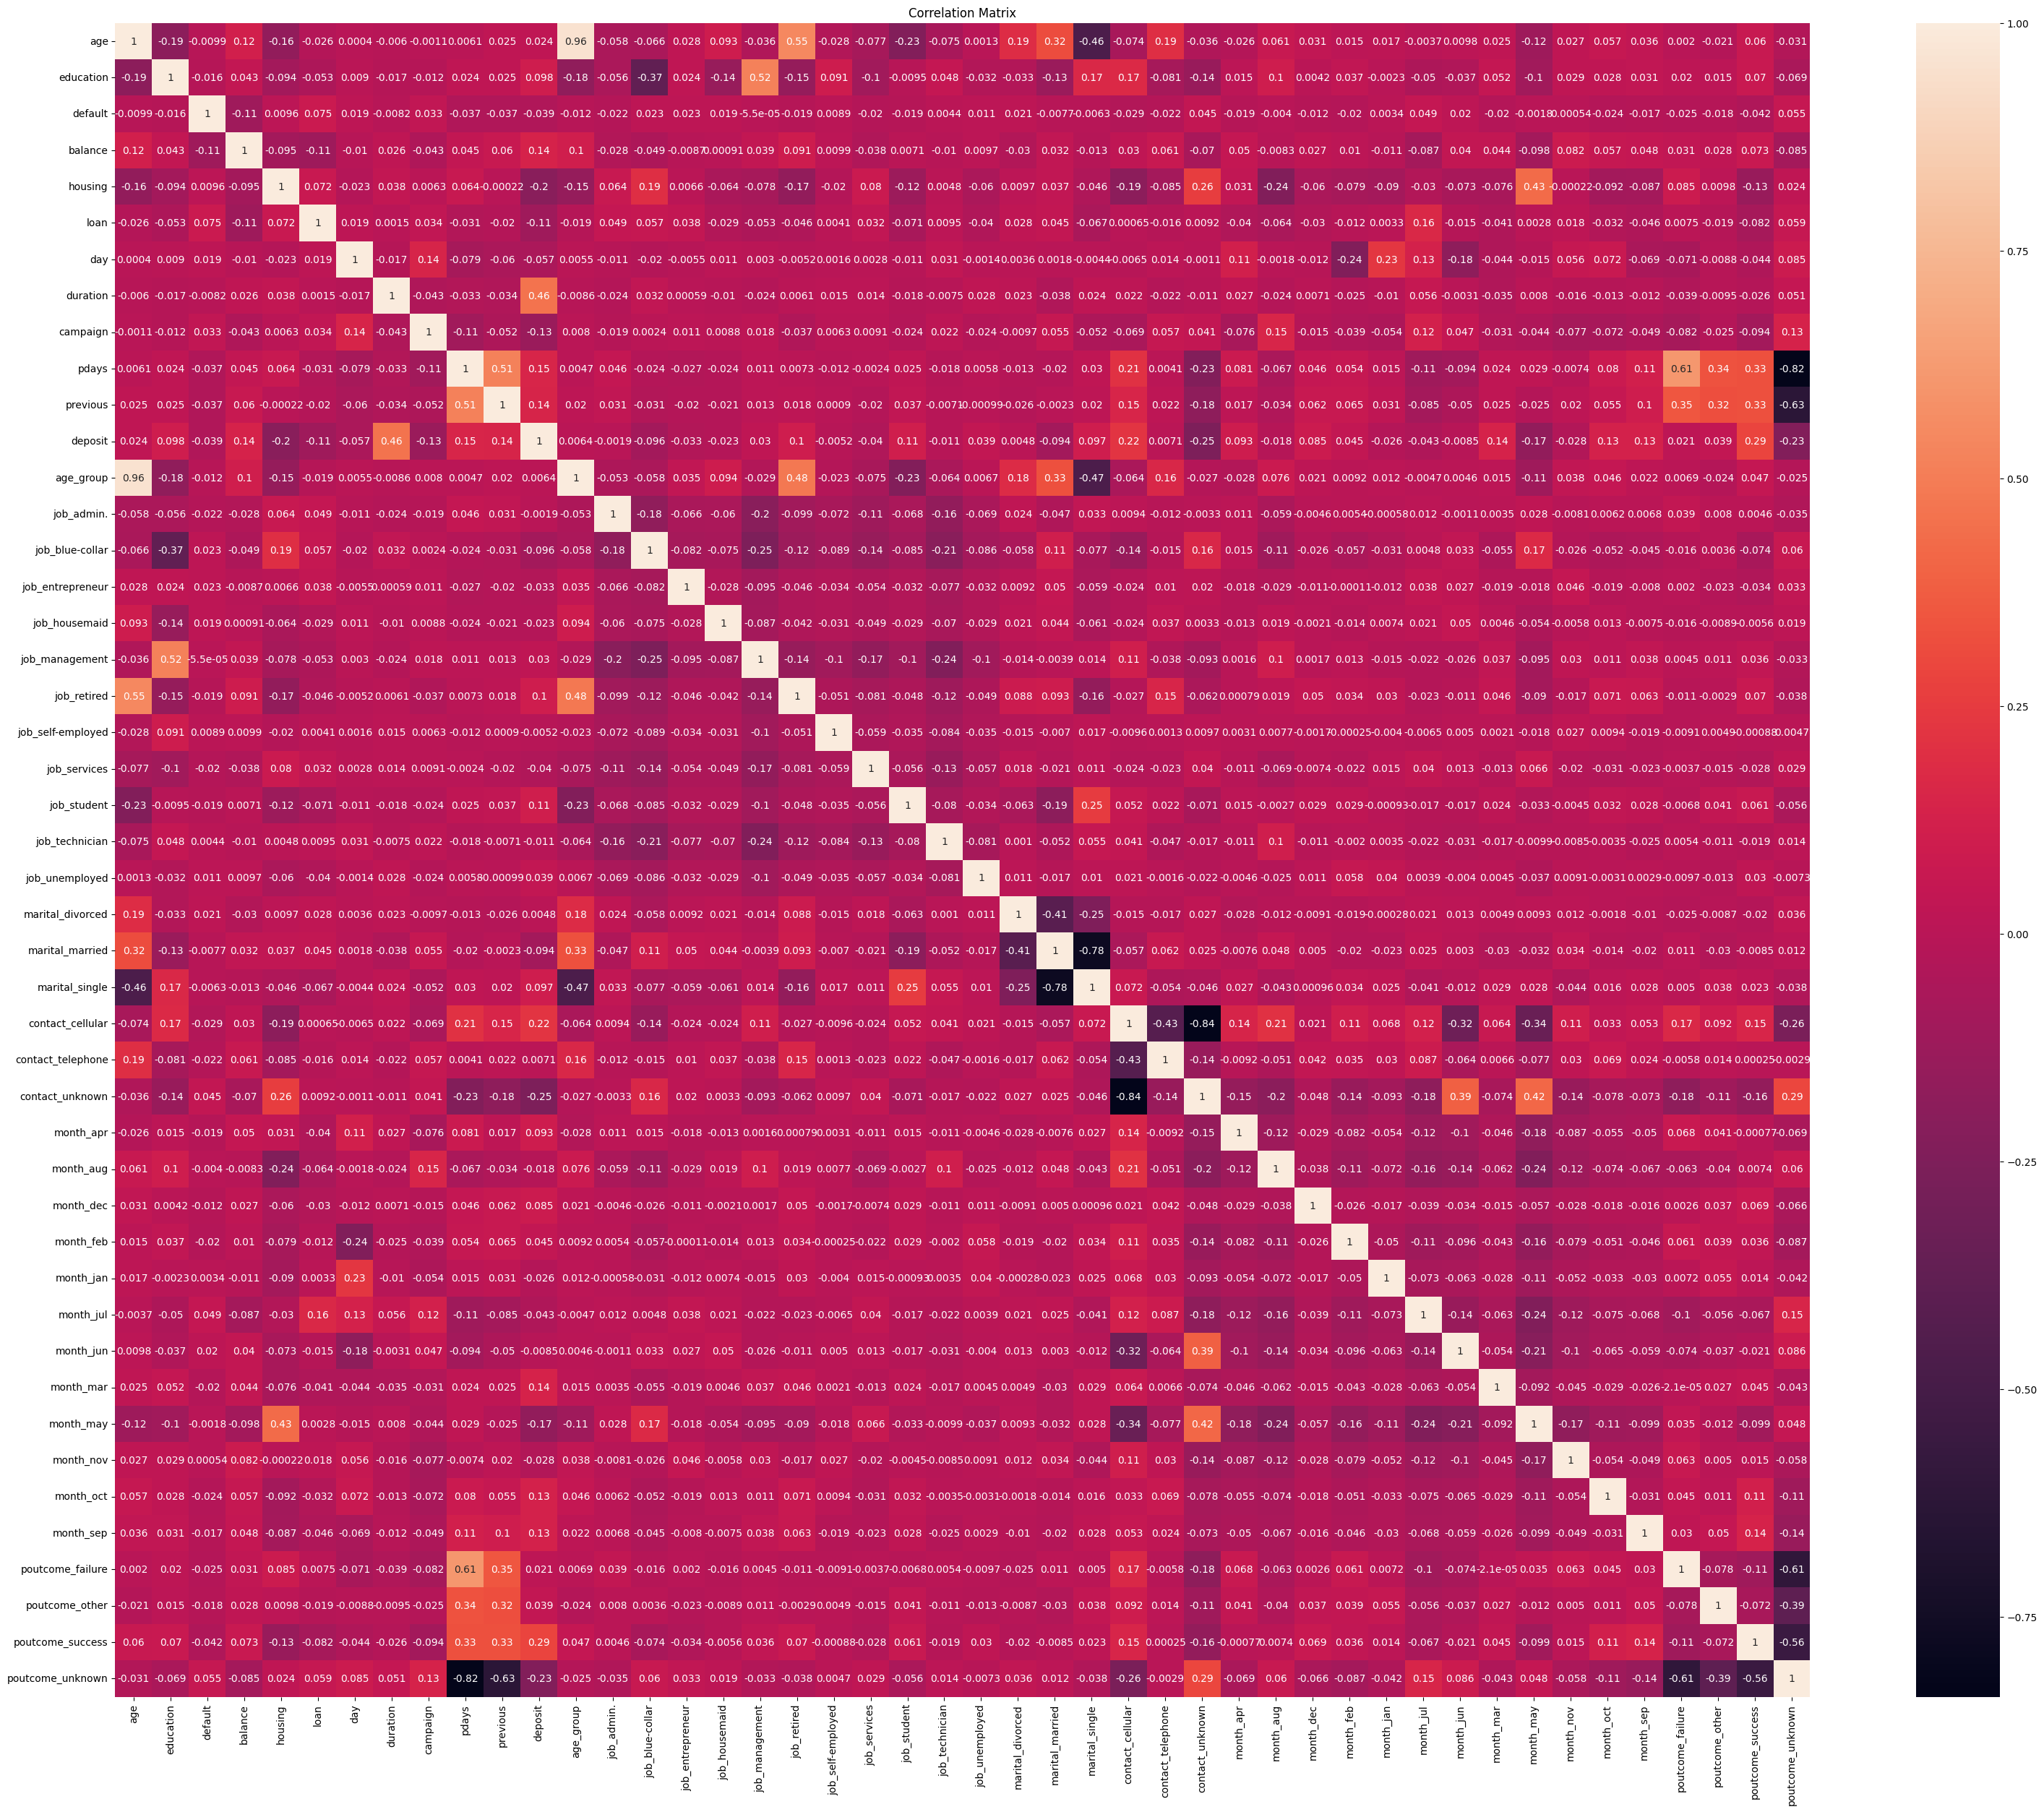

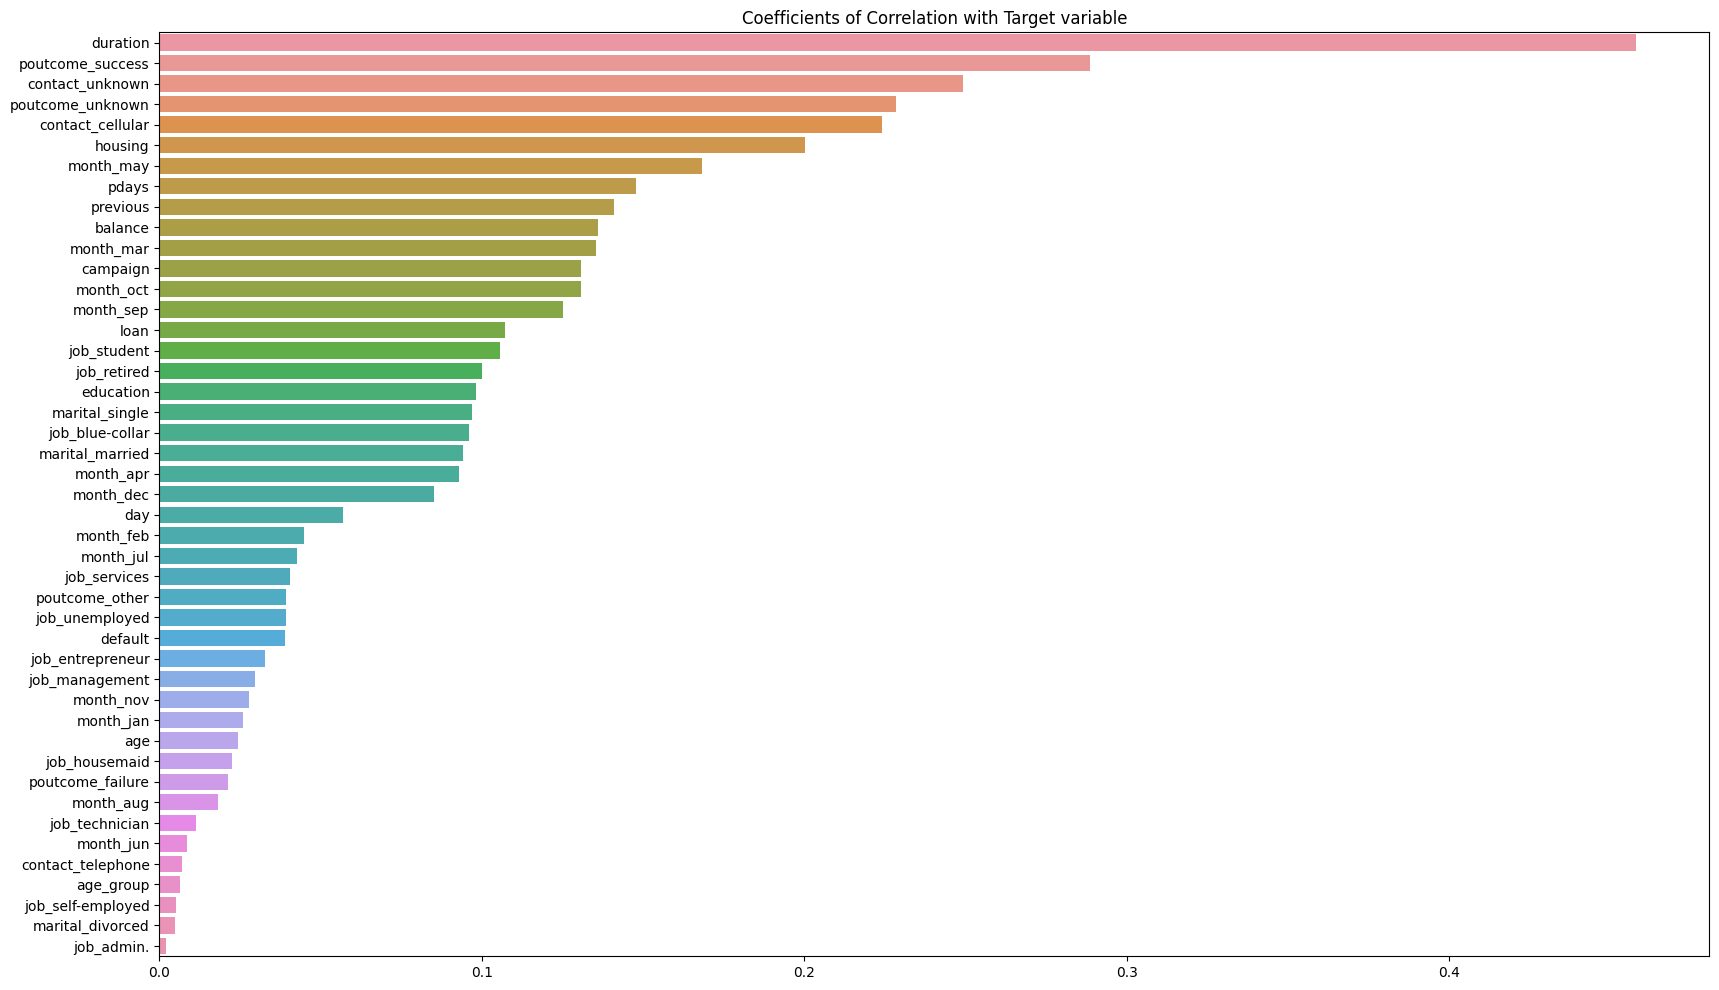

In [25]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fix, ax = plt.subplots(figsize=(30, 24))
plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
sns.heatmap(df.corr(), annot=True)

#Задание 4.5
#Расставьте признаки, в наибольшей степени коррелирующие с целевой переменной, по убыванию силы линейной взаимосвязи.
corr_matrix = df.corr().abs()
target_corr = corr_matrix['deposit'].drop('deposit').sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(20, 12))
plt.title('Coefficients of Correlation with Target variable')
sns.barplot(x=target_corr.values, y=target_corr.index)

### Задания 7 и 8

In [26]:
X = df.drop(['deposit', 'age', 'job', 'marital', 'contact', 'month', 'poutcome'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

#Задание 4.7
#Каким получился размер тестовой выборки?
X_test.shape

(3335, 44)

In [27]:
# рассчитайте необходимые показатели
#Задание 4.8
#Каково среднее значение целевой переменной на тестовой выборке?
#Ответ округлите до двух знаков после точки-разделителя.
y_test.mean()

0.46326836581709147

### Задание 9

In [28]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)

# keep only 15 features
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

#Задание 4.9
#Укажите одну переменную, не попавшую в данный перечень:
selector.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [29]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Задание 4.10
#Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки.
#Ответ округлите до двух знаков после точки-разделителя.
X_test_scaled[:, 0].mean()

0.46823674223097866

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [30]:
# обучите логистическую регрессию и рассчитайте метрики качества
logistic_regression = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
logistic_regression.fit(X_train_scaled, y_train)

y_pred_lr = logistic_regression.predict(X_test_scaled)

#Задание 5.1
#Для получившейся модели вычислите значение accuracy на тестовой выборке.
#Ответ округлите до двух знаков после точки-разделителя.
print('The accuracy score for Train data set using LogisticRegression: ', metrics.accuracy_score(y_train, logistic_regression.predict(X_train_scaled)))
print('The accuracy score for Test data set using LogisticRegression: ', metrics.accuracy_score(y_test, y_pred_lr))

The accuracy score for Train data set using LogisticRegression:  0.8209748892171345
The accuracy score for Test data set using LogisticRegression:  0.8041979010494753


### Задания 2,3,4

The accuracy score for Train data set using Decision Tree Classifier:  0.9997045790251108
The accuracy score for Test data set using Decision Tree Classifier:  0.7535232383808096
We can observe that when using defaul settings for the Decision Tree model, our Train data set is overfitted, while our Test data set is underfitted.



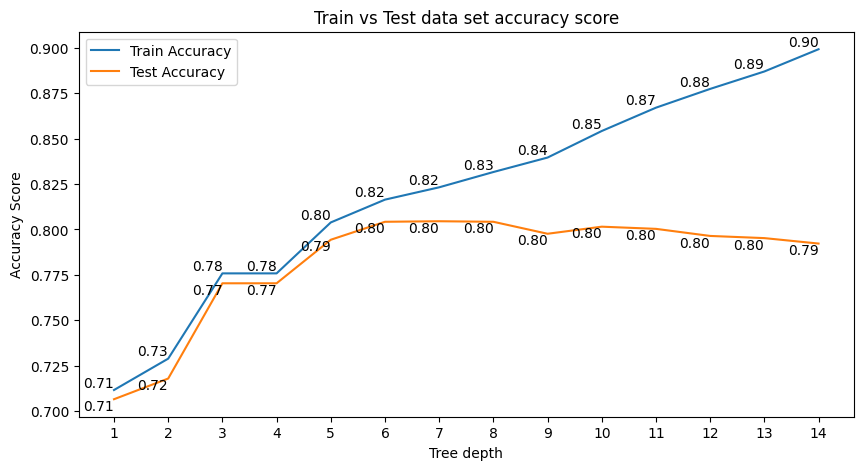

From the above plot we can see that the maximum accuracy score for Test data set we getting when the depth of the tree is equal 6.
Also at this depth our Train data set is not overfitted


In [31]:
# обучите решающие деревья, настройте максимальную глубину
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
decision_tree.fit(X_train_scaled, y_train)

y_pred_dt = decision_tree.predict(X_test_scaled)

#Задание 5.2
#Что можно наблюдать после реализации алгоритма и оценки его качества?
print('The accuracy score for Train data set using Decision Tree Classifier: ', metrics.accuracy_score(y_train, decision_tree.predict(X_train_scaled)))
print('The accuracy score for Test data set using Decision Tree Classifier: ', metrics.accuracy_score(y_test, y_pred_dt))
print('We can observe that when using defaul settings for the Decision Tree model, our Train data set is overfitted, while our Test data set is underfitted.\n')


# Переберите различные максимальные глубины деревьев и найдите глубину дерева,
# для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения
# (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

# Задание 5.3
#Какое наибольшее значение accuracy у вас получилось? Ответ округлите до двух знаков после точки-разделителя.

# create arrays to save accuracy scores for Train and Test data sets
train_accuracy = []
test_accuracy = []
tree_depth = []

for depth in range(1, 15):
  #initialize model
  decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
  decision_tree.fit(X_train_scaled, y_train)

  # predict
  y_train_predict = decision_tree.predict(X_train_scaled)
  y_test_predict = decision_tree.predict(X_test_scaled)

  # get accuracy score for Test and Train data sets prediction
  train_accuracy.append(metrics.accuracy_score(y_train, y_train_predict))
  test_accuracy.append(metrics.accuracy_score(y_test, y_test_predict))
  tree_depth.append(depth)


# create line plot
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(x=tree_depth, y=train_accuracy, ax=ax, label='Train Accuracy')
sns.lineplot(x=tree_depth, y=test_accuracy, ax=ax, label='Test Accuracy')

# Annotate each point with its y-value
for i in range(len(tree_depth)):
    ax.text(tree_depth[i], train_accuracy[i], f'{train_accuracy[i]:.2f}', ha='right', va='bottom')
    ax.text(tree_depth[i], test_accuracy[i], f'{test_accuracy[i]:.2f}', ha='right', va='top')

ax.set_xticks(tree_depth)
ax.set_title('Train vs Test data set accuracy score')
ax.set_xlabel('Tree depth')
ax.set_ylabel('Accuracy Score')

plt.show()

print('From the above plot we can see that the maximum accuracy score for Test data set we getting when the depth of the tree is equal 6.')
print('Also at this depth our Train data set is not overfitted')

### Задание 5

In [32]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7],
              'min_samples_split': [2, 5, 7, 10]}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
y_test_predict = grid_search.predict(X_test_scaled)

# Задание 5.5
#Оцените метрику на тестовой выборке для наилучшей комбинации перебираемых параметров.
#В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.
print('The best values for hyper params: ', grid_search.best_params_)
print('The F1 score on Test data set is: {:.2f}'.format(metrics.f1_score(y_test, y_test_predict)))

The best values for hyper params:  {'max_depth': 7, 'min_samples_split': 10}
The F1 score on Test data set is: 0.78


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [33]:
# обучите на ваших данных случайный лес
#Задание 6.1
#Оцените метрики accuracy и recall для построенной модели на тестовой выборке.
#В качестве ответов введите значения метрик. Ответ округлите до двух знаков после точки-разделителя.

rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_scaled, y_train)

y_train_predict = rf.predict(X_train_scaled)
y_test_predict = rf.predict(X_test_scaled)

print('The metrics for Train using RandomForest: \n', metrics.classification_report(y_train, y_train_predict))
print('The metrics for Test using RandomForest: \n', metrics.classification_report(y_test, y_test_predict))

The metrics for Train using RandomForest: 
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.86      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

The metrics for Test using RandomForest: 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [34]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
#Задание 6.2
#Для построенной модели оцените метрику на тестовой выборке.
#В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

gradient_boosting = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

gradient_boosting.fit(X_train_scaled, y_train)

y_train_predict = gradient_boosting.predict(X_train_scaled)
y_test_predict = gradient_boosting.predict(X_test_scaled)

print('The F1 score for Train using Gradient Boosting: {:.2f}'.format(metrics.f1_score(y_train, y_train_predict)))
print('The F1 score for Test using Gradient Boosting: {:.2f}'.format(metrics.f1_score(y_test, y_test_predict)))
print('The Classification Report for Test data: \n', metrics.classification_report(y_test, y_test_predict))

The F1 score for Train using Gradient Boosting: 0.87
The F1 score for Test using Gradient Boosting: 0.81
The Classification Report for Test data: 
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задание 4

In [36]:
# объедините уже известные вам алгоритмы с помощью стекинга
#Задание 6.4
#Для построенной модели оцените метрику precision на тестовой выборке.
#В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.
gradient_boosting = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

logistic_regression = linear_model.LogisticRegression(
    solver='sag',
    max_iter=1000,
    random_state=42
)

stacking = ensemble.StackingClassifier(
    estimators=[('gb', gradient_boosting), ('rf', rf), ('lr', logistic_regression)],
    final_estimator=logistic_regression
)

stacking.fit(X_train_scaled, y_train)

y_train_predict = stacking.predict(X_train_scaled)
y_test_predict = stacking.predict(X_test_scaled)

print('The precision score for Train data using Stacking: {:.2f}'.format(metrics.precision_score(y_train, y_train_predict)))
print('The precision score for Test data using Stacking: {:.2f}'.format(metrics.precision_score(y_test, y_test_predict)))

The precision score for Train data using Stacking: 0.84
The precision score for Test data using Stacking: 0.81


### Задание 5

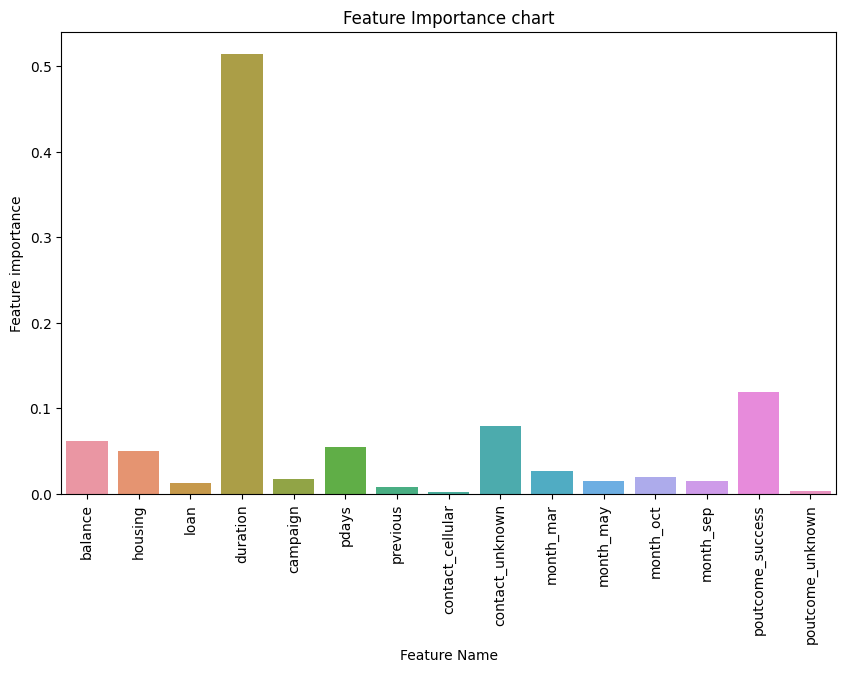

In [66]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
gradient_boosting.fit(X_train_scaled, y_train)
feature_importance = gradient_boosting.feature_importances_.tolist()

feature_name = selector.get_feature_names_out().tolist()

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_name, y=feature_importance, ax=ax)
ax.set_ylabel('Feature importance')
ax.set_xlabel('Feature Name')
ax.set_title('Feature Importance chart')
ax.set_xticklabels(feature_name, rotation=90)

plt.show()

### Задания 6,7,8

In [74]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch. Однако вы знаете, что это не единственный способ.
#Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna.
#Примените его для оптимизации гиперпараметров. Для перебора возьмите случайный лес и следующие параметры:

#         n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
#         max_depth = trial.suggest_int('max_depth', 10, 30, 1);
#         min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

#Задание 6.6
#Введите значение метрики на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.
#!pip install optuna
import optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=42
  )

  model.fit(X_train_scaled, y_train)

  score = cross_val_score(
      estimator=model,
      X=X_train_scaled,
      y=y_train,
      scoring='f1',
      cv=5,
      n_jobs=-1
  )

  return np.mean(score)

study = optuna.create_study(direction='maximize')
study.optimize(optuna_rf, n_trials=20)

print('The best params for study: \n', study.best_params)
print('The best f1 score on Train data: ', study.best_value)

#teach model using the best params from Optuna
rf = ensemble.RandomForestClassifier(**study.best_params, random_state=42)

rf.fit(X_train_scaled, y_train)

y_train_predict = rf.predict(X_train_scaled)
y_test_predict = rf.predict(X_test_scaled)

print('The F1 score for Train data: ', metrics.f1_score(y_train, y_train_predict))
print('The F1 score for Test data: ', metrics.f1_score(y_test, y_test_predict))
print('The Accuracy score for Test data: ', metrics.accuracy_score(y_test, y_test_predict))

[I 2023-12-31 23:20:18,355] A new study created in memory with name: no-name-470a3157-e632-4fb5-8d1c-c91da44abfa7
[I 2023-12-31 23:20:34,509] Trial 0 finished with value: 0.8194666833977973 and parameters: {'n_estimators': 191, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8194666833977973.
[I 2023-12-31 23:20:39,928] Trial 1 finished with value: 0.8182076634230715 and parameters: {'n_estimators': 159, 'max_depth': 11, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8194666833977973.
[I 2023-12-31 23:20:46,225] Trial 2 finished with value: 0.8213389570607917 and parameters: {'n_estimators': 173, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8213389570607917.
[I 2023-12-31 23:20:51,932] Trial 3 finished with value: 0.8185646691339896 and parameters: {'n_estimators': 108, 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8213389570607917.
[I 2023-12-31 23:20:58,301] Trial 4 finished with value: 0.821428857606046

The best params for study: 
 {'n_estimators': 174, 'max_depth': 14, 'min_samples_leaf': 4}
The best f1 score on Train data:  0.8228332366511933
The F1 score for Train data:  0.8599409295818436
The F1 score for Test data:  0.8210792047964658
The Accuracy score for Test data:  0.8299850074962519
